# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [71]:
# импорт библиотек

! pip install scikit-learn --upgrade
! pip install category_encoders
! pip install shap
! pip install catboost
! pip Install LightGBM
! pip install phik

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import shap
import warnings
import lightgbm 
import phik

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import  RobustScaler
from category_encoders import CatBoostEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

ERROR: unknown command "Install" - maybe you meant "install"


In [72]:
# загрузка данных

pth = '/datasets/autos.csv'

if os.path.exists(pth):
    df = pd.read_csv(pth)
else:
    print('Загрузка не удалась')

In [73]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
199656,2016-03-15 16:40:11,300,small,1997,manual,60,polo,150000,11,petrol,volkswagen,no,2016-03-15 00:00:00,0,88410,2016-03-15 16:40:11
274157,2016-03-09 09:36:56,650,NaN,2017,manual,115,3er,150000,1,NaN,bmw,NaN,2016-03-09 00:00:00,0,32312,2016-03-09 09:36:56
291470,2016-03-18 12:06:21,1650,sedan,1999,manual,75,astra,100000,6,petrol,opel,no,2016-03-18 00:00:00,0,35394,2016-03-19 14:28:21
90877,2016-03-28 23:53:59,3100,small,2005,manual,75,clio,125000,12,petrol,renault,no,2016-03-28 00:00:00,0,45279,2016-04-05 15:18:40
162474,2016-03-08 21:47:56,2900,NaN,2016,auto,0,c_klasse,150000,12,NaN,mercedes_benz,NaN,2016-03-08 00:00:00,0,47259,2016-03-13 02:17:19


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные выгрузились корректно. дф содержит 354369 объектов и 16 признаков. Признак Price - целевой.

### предобработка

Сразу убрем не инфоративные признаки.

In [75]:
df.duplicated().sum()

4

In [76]:
df = df.drop_duplicates().reset_index(drop=True)

Удалили не информативные признаки. 

<AxesSubplot:>

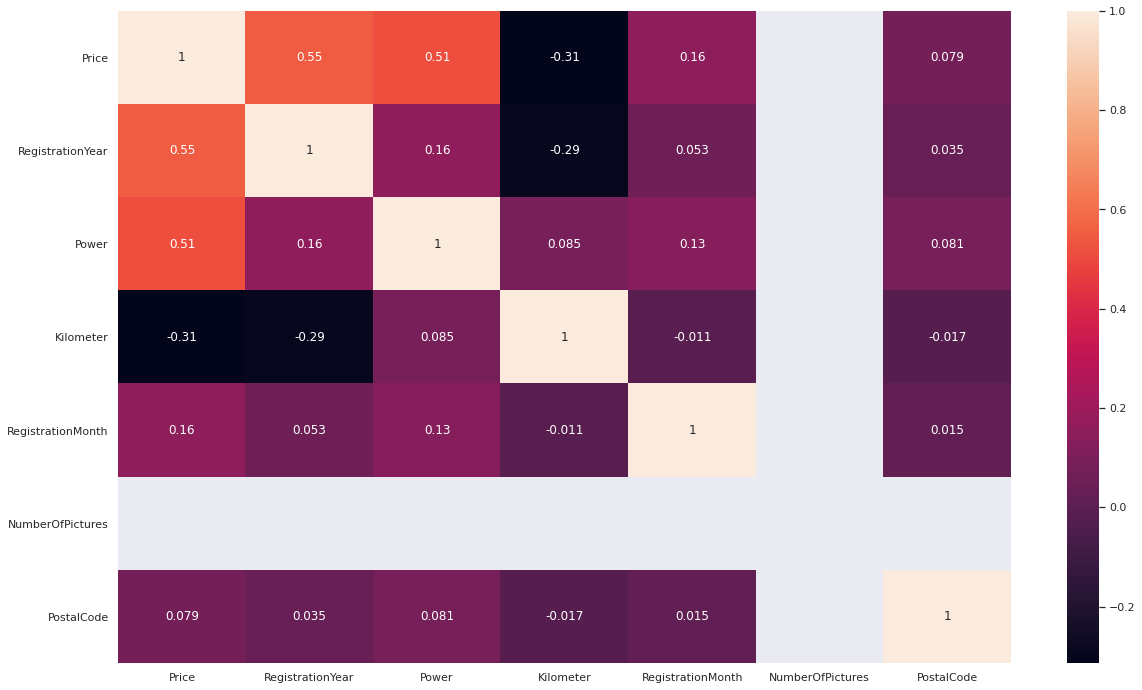

In [77]:
spearman = df.corr(method='spearman')
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(data=spearman,annot=True)

In [78]:
df = df.drop(['DateCrawled','RegistrationMonth','NumberOfPictures', 'PostalCode','LastSeen'], axis= 1)

удалили не информативные признаки ( и phik на них ругался )

In [79]:
df.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
Price,1.00,0.27,0.01,0.32,0.01,0.58,0.31,0.26,0.36,0.38,0.06
VehicleType,0.27,1.00,NaN,0.29,0.01,0.92,0.17,0.33,0.63,0.08,0.05
RegistrationYear,0.01,NaN,1.00,0.00,0.09,0.08,0.23,0.04,0.05,0.01,0.00
Gearbox,0.32,0.29,0.00,1.00,0.01,0.65,0.02,0.15,0.52,0.04,0.02
Power,0.01,0.01,0.09,0.01,1.00,0.00,0.00,0.01,0.00,0.01,0.00
Model,0.58,0.92,0.08,0.65,0.00,1.00,0.44,0.55,1.00,0.16,0.25
Kilometer,0.31,0.17,0.23,0.02,0.00,0.44,1.00,0.15,0.28,0.11,0.05
FuelType,0.26,0.33,0.04,0.15,0.01,0.55,0.15,1.00,0.32,0.04,0.01
Brand,0.36,0.63,0.05,0.52,0.00,1.00,0.28,0.32,1.00,0.11,0.10
Repaired,0.38,0.08,0.01,0.04,0.01,0.16,0.11,0.04,0.11,1.00,0.03


есть корреляция у целевой переменной с годом выпуска, мощностью и пробегом, phik добавляет связь с видом топлива и коробкой.

In [80]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
DateCreated             0
dtype: int64

In [81]:
df['Repaired'].value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

Предпологаю, что если этот параметр не указали - машина была в ремонте. Продавцу выгодно указать обратное, ели это действительно так. Заполним пропуски 'yes'

In [82]:
df['Repaired'] = df['Repaired'].fillna('yes')

In [83]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [84]:
df['Model'] = df['Model'].fillna(df.groupby(['Brand','Price'])['Model'].transform(lambda x: x.value_counts().index[0] if x.count() !=0 else 'unknown' ))

In [85]:
df['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [86]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby(['Model','Brand'])['VehicleType'].transform(lambda x: x.value_counts().index[0] if x.count() !=0 else 'other' ))

In [87]:
df['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [88]:
df.loc[(df.FuelType == 'gasoline'),'FuelType']='petrol'
df.loc[(df.FuelType == 'lpg'),'FuelType']='gas'
df.loc[(df.FuelType == 'cng'),'FuelType']='gas'

In [89]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().index[0] if x.count() !=0 else 'other' ))

In [90]:
df['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [91]:
df['Gearbox'] = df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().index[0] if x.count() !=0 else 'manual' ))

In [92]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

count   354,365.00
mean      2,004.23
std          90.23
min       1,000.00
25%       1,999.00
50%       2,003.00
75%       2,008.00
max       9,999.00
Name: RegistrationYear, dtype: float64


<AxesSubplot:>

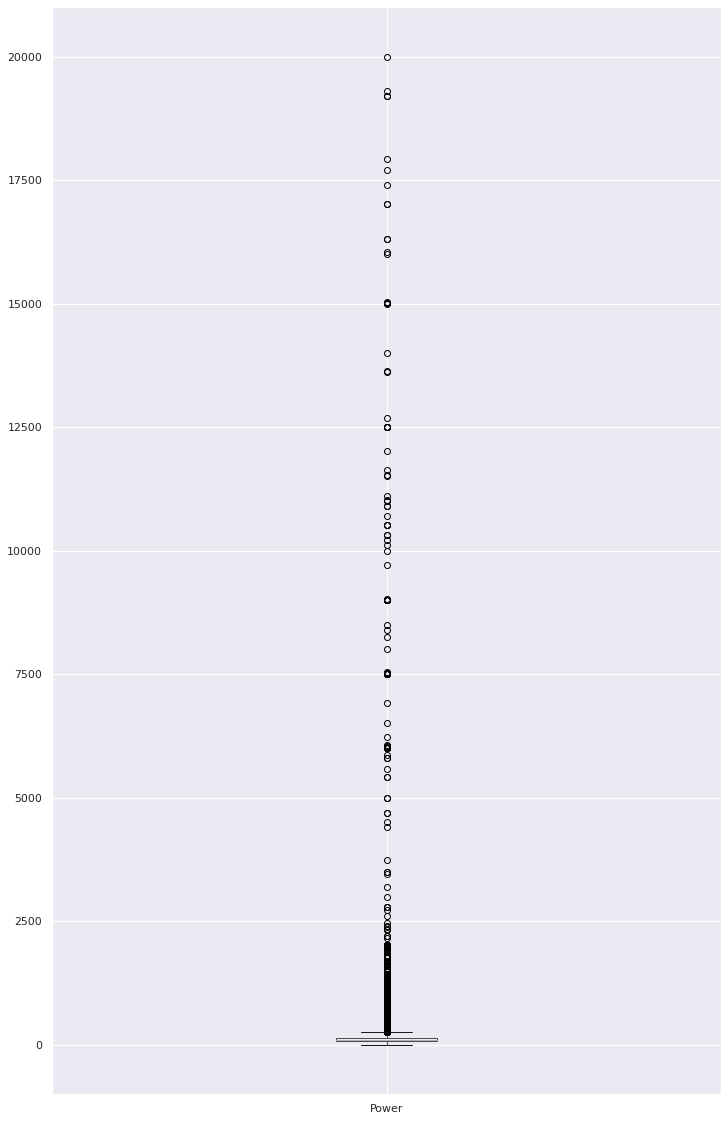

In [93]:
print (df['RegistrationYear'].describe())

df.boxplot(column=['Power'], figsize=(12,20))

много ошибок 

In [94]:
df = df[df.RegistrationYear <= 2016]
df = df[df.RegistrationYear >= 1950]
df = df.reset_index(drop = True)

Сделаем признак возраст авто - он заменит 'DateCreated' и 'RegistrationYear'

In [95]:
df['DateCreated'].value_counts()

2016-04-03 00:00:00    13174
2016-04-04 00:00:00    12781
2016-03-20 00:00:00    12406
2016-03-12 00:00:00    12322
2016-03-21 00:00:00    12174
                       ...  
2016-01-03 00:00:00        1
2015-06-18 00:00:00        1
2016-01-08 00:00:00        1
2015-09-09 00:00:00        1
2014-03-10 00:00:00        1
Name: DateCreated, Length: 108, dtype: int64

In [96]:
df['DateCreated'] = df.DateCreated.apply(lambda x:x.split(' ')[0])

In [97]:
df['Year'] = pd.DatetimeIndex(df['DateCreated']).year

In [98]:
df['Year'].unique()

array([2016, 2015, 2014])

In [99]:
df['AgeCar'] = df['Year'] - df['RegistrationYear']

In [100]:
df['AgeCar'].unique()

array([23,  5, 12, 15,  8, 21, 36,  2, 18, 11,  0,  9,  7, 14, 19, 26, 35,
       13, 22, 25, 32, 10, 17,  4,  6, 16, 24,  3, 20, 31, 27,  1, 34, 40,
       33, 43, 47, 45, 29, 30, 28, 46, 51, 42, 37, 61, 38, 44, 48, 39, 55,
       56, 50, 41, 53, 52, 62, 58, 49, 57, 60, 54, 59, 65, 63, 66, 64])

In [101]:
df = df.drop(['RegistrationYear','DateCreated','Year'], axis= 1)

In [102]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,"339,589.00",NaN,NaN,NaN,"4,471.59","4,545.26",0.00,"1,100.00","2,799.00","6,500.00","20,000.00"
VehicleType,339589,8,sedan,101832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gearbox,339589,2,manual,273511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,"339,589.00",NaN,NaN,NaN,111.05,186.90,0.00,69.00,105.00,143.00,"20,000.00"
Model,339589,251,golf,30393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,"339,589.00",NaN,NaN,NaN,"128,124.16","37,842.14","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
FuelType,339589,5,petrol,333383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,339589,40,volkswagen,73164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Repaired,339589,2,no,240045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgeCar,"339,589.00",NaN,NaN,NaN,13.47,6.84,0.00,9.00,13.00,17.00,66.00


есть странные значение price и power

<AxesSubplot:>

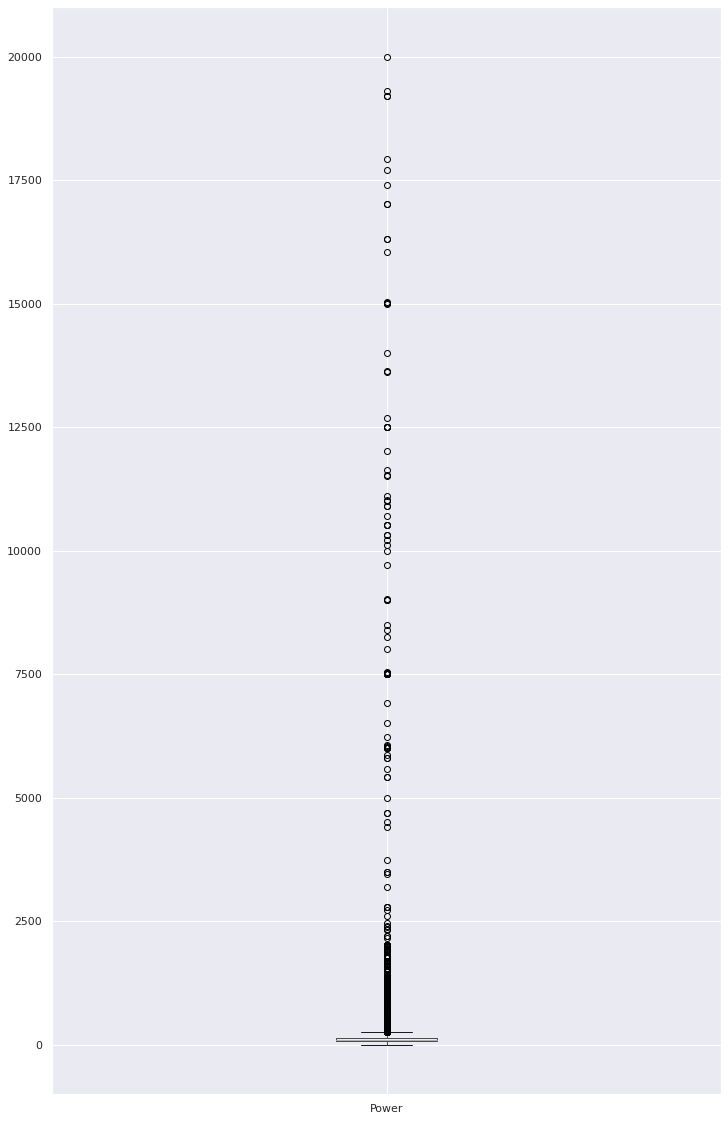

In [103]:
df.boxplot(column=['Power'], figsize=(12,20))

In [104]:
df['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
         118,   193,    99,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   286,   232,   150,
         156,    80,    82,    90,   155,    54,   185,    87,   180,
          86,    84,   224,   235,   200,   178,   265,    77,   110,
         144,   120,   116,   184,   126,   204,    88,   194,    64,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    73,   192,    68,    66,   299,    74,
          52,   147,   310,    71,    97,    65,   239,   203,     5,
         300,   103,    85,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,   132,   234,   158,    39,    92,    51,   135,    59,
          53,   209,

In [105]:
df.loc[(df.Power > 400 ),'Power']= 0
df.loc[(df.Power < 50 ),'Power']= 0
df['Power'] = df['Power'].replace(0 , np.NaN)
median_power = df.groupby('Model')['Power'].transform('median')
df['Power'] = df['Power'].fillna(median_power)

In [106]:
df['Power'].unique()

array([101. , 190. , 163. ,  75. ,  69. , 102. , 109. ,  50. , 125. ,
       105. , 140. , 115. , 131. ,  60. , 136. , 160. , 231. , 118. ,
       193. ,  99. , 113. , 218. , 122. , 129. ,  70. ,  65. , 306. ,
        95. ,  61. , 177. , 170. ,  55. , 143. , 155. , 286. , 232. ,
       150. , 156. ,  80. ,  82. ,  90. ,  54. , 185. ,  87. , 180. ,
        86. ,  84. , 224. , 235. , 200. , 178. , 265. ,  77. , 110. ,
       144. , 120. , 116. , 184. , 126. , 204. , 133. ,  88. , 194. ,
        58. ,  64. , 305. , 197. , 179. , 250. , 245. , 313. , 165. ,
        98. , 130. , 114. , 211. ,  56. , 201. , 213. , 107. ,  83. ,
       174. , 100. , 220. , 145. ,  73. , 192. ,  68. ,  66. , 299. ,
        74. ,  52. , 147. , 310. ,  71. ,  97. , 239. , 203. , 119. ,
       300. , 103. ,  85. , 258. , 320. ,  63. ,  81. , 148. ,  53. ,
       230. , 280. , 260. , 104. , 188. , 333. , 186. , 117. , 141. ,
       132. , 234. , 158. ,  92. ,  51. , 135. ,  59. , 209. , 146. ,
        67. , 106. ,

In [107]:
df.isna().sum()

Price          0
VehicleType    0
Gearbox        0
Power          2
Model          0
Kilometer      0
FuelType       0
Brand          0
Repaired       0
AgeCar         0
dtype: int64

In [108]:
df = df.dropna().reset_index(drop=True)

<AxesSubplot:>

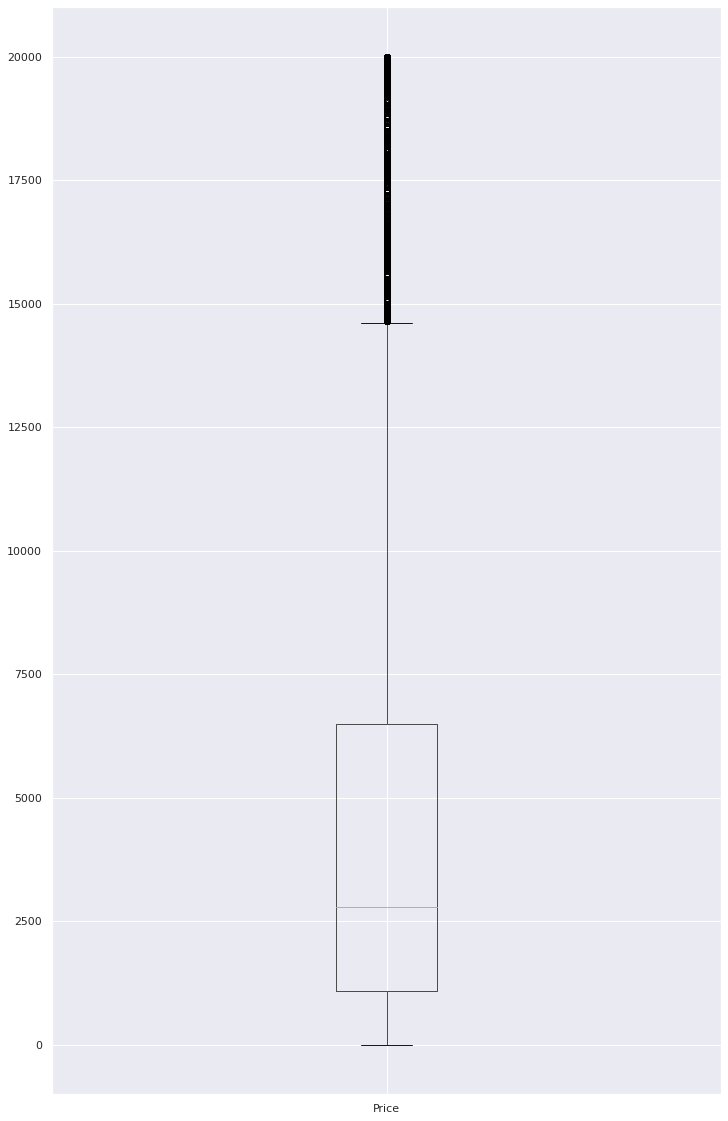

In [109]:
df.boxplot(column=['Price'], figsize=(12,20))

In [110]:
df.loc[(df.Price < 500 ),'Price']= 0
df['Price'] = df['Price'].replace(0 , np.NaN)
median_price = df.groupby('Model')['Price'].transform('median')
df['Price'] = df['Price'].fillna(median_price)

In [111]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,"339,587.00",NaN,NaN,NaN,"4,712.09","4,403.66",500.00,"1,490.00","2,999.00","6,500.00","20,000.00"
VehicleType,339587,8,sedan,101832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gearbox,339587,2,manual,273509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,"339,587.00",NaN,NaN,NaN,119.60,51.00,50.00,75.00,110.00,145.00,400.00
Model,339587,250,golf,30393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,"339,587.00",NaN,NaN,NaN,"128,124.53","37,841.85","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
FuelType,339587,5,petrol,333381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,339587,40,volkswagen,73164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Repaired,339587,2,no,240045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgeCar,"339,587.00",NaN,NaN,NaN,13.47,6.84,0.00,9.00,13.00,17.00,66.00


Целевой признак - Price. Минимальная цена 500 максимальная 20.000, средняя цена 4.700, медиальная 3.000. Вероятно есть дорогие модели которые "делают разницу". Самый частый кузов - седан, модель - golf, марка - фолькваген, средний пробег - 128.000, мощность 120, возраст 13 лет, чаще продают автомобилии, которые не были в ремонте.

графическая часть

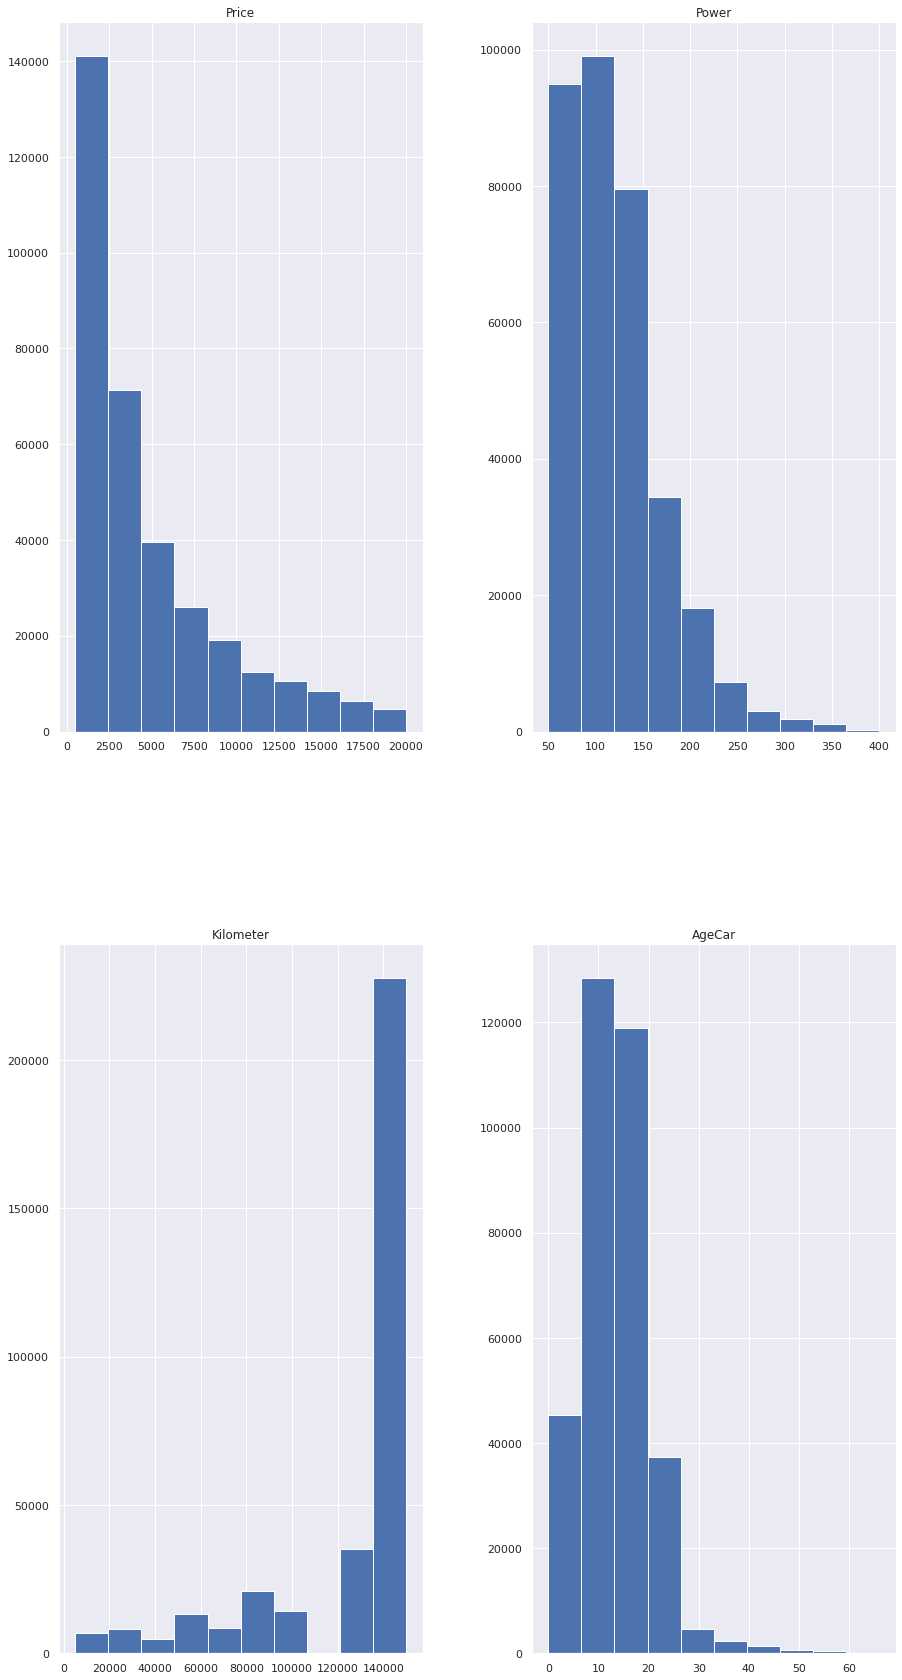

In [112]:
df.hist(figsize=(15, 30))
plt.show()

Распределение целевой переменной - логнормальное, в остальном соотвествует логике. 

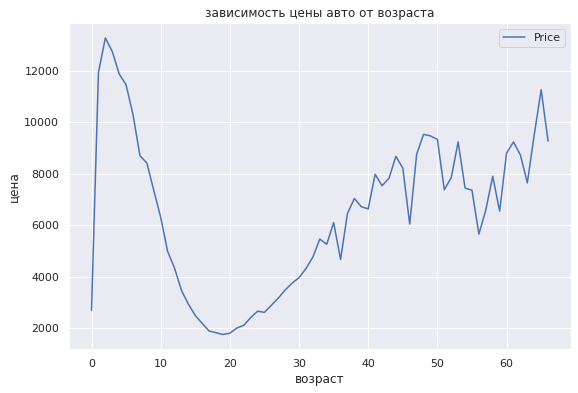

In [113]:
df.pivot_table(index='AgeCar', values='Price').plot(title='зависимость цены авто от возраста', grid=True, style='-', figsize=(9, 6)).set(xlabel="возраст", ylabel="цена")
plt.show()

чем моложе авто - тем дороже, но у авто после 30 лет цена так же бывает высокой. Раритетные авто.

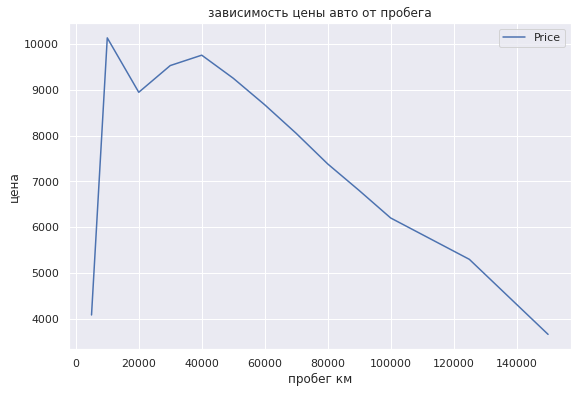

In [114]:
df.pivot_table(index='Kilometer', values='Price').plot(title='зависимость цены авто от пробега', grid=True, style='-', figsize=(9, 6)).set(xlabel="пробег км", ylabel="цена")
plt.show()

Тут все логично. Больше пробег - ниже цена

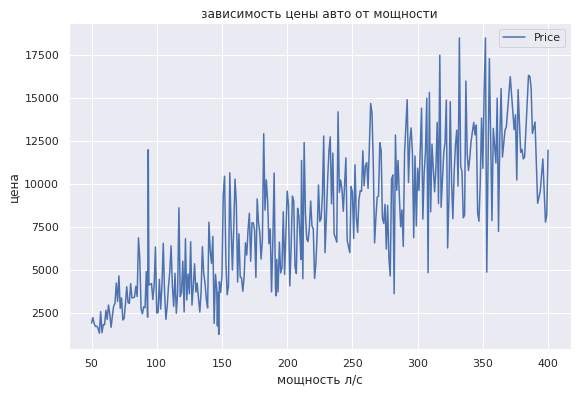

In [115]:
df.pivot_table(index='Power', values='Price').plot(title='зависимость цены авто от мощности', grid=True, style='-', figsize=(9, 6)).set(xlabel="мощность л/с", ylabel="цена")
plt.show()

<AxesSubplot:xlabel='VehicleType', ylabel='Price'>

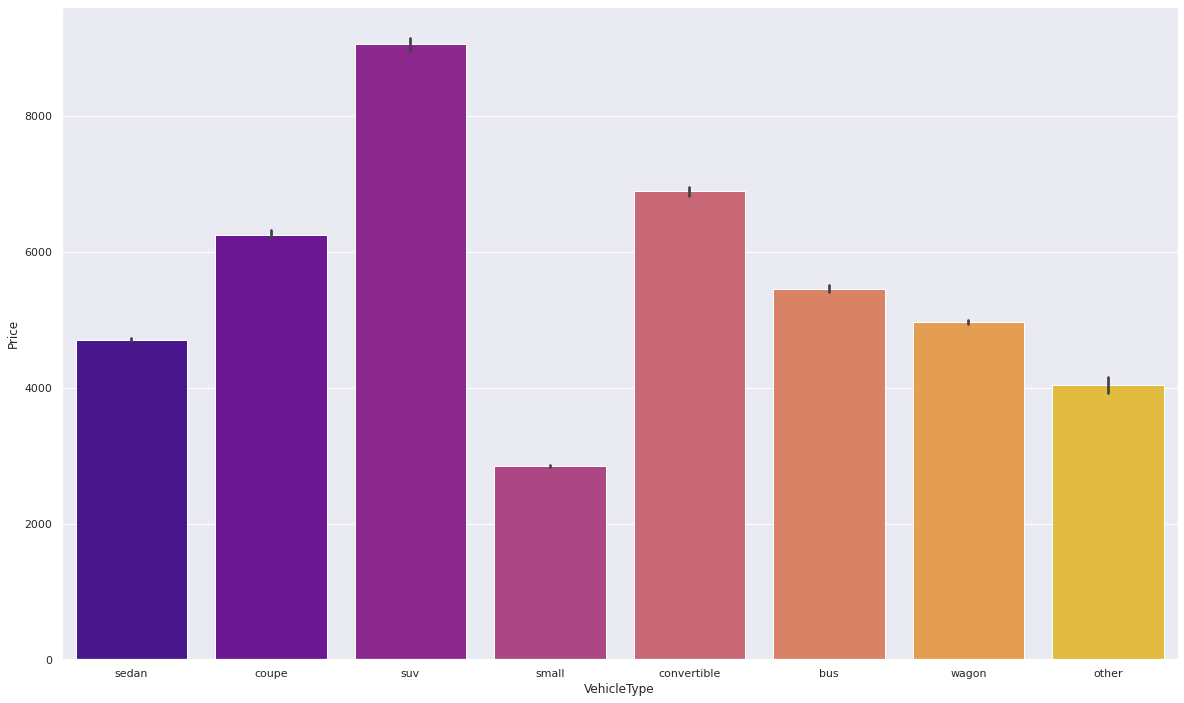

In [116]:
sns.barplot(x ='VehicleType', y ='Price', data = df, palette ='plasma')

В среднем самые дорогие авто - suv. Самые дешевые - small. Остальные классы примерно одинаково оцениваются.

<AxesSubplot:xlabel='FuelType', ylabel='Price'>

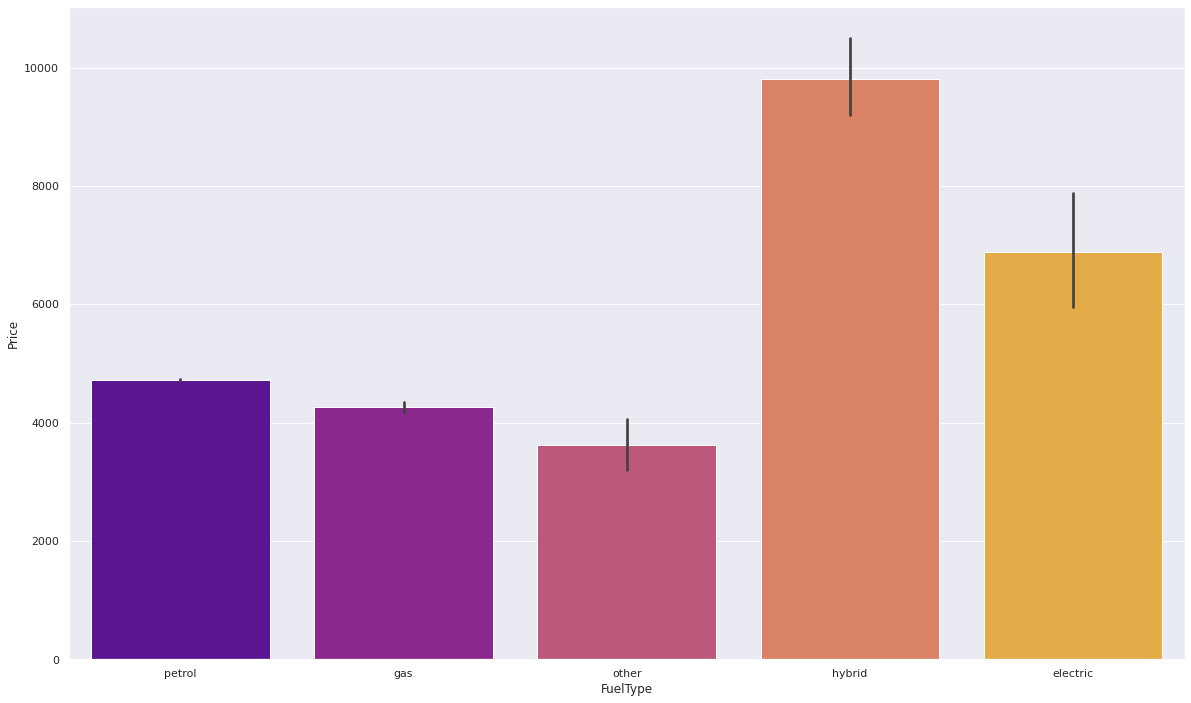

In [117]:
sns.barplot(x ='FuelType', y ='Price', data = df, palette ='plasma')

Гибриды - самые дороги авто, далее идут электромобили. Остальные примерно одинаковая стоимость.

<AxesSubplot:xlabel='Gearbox', ylabel='Price'>

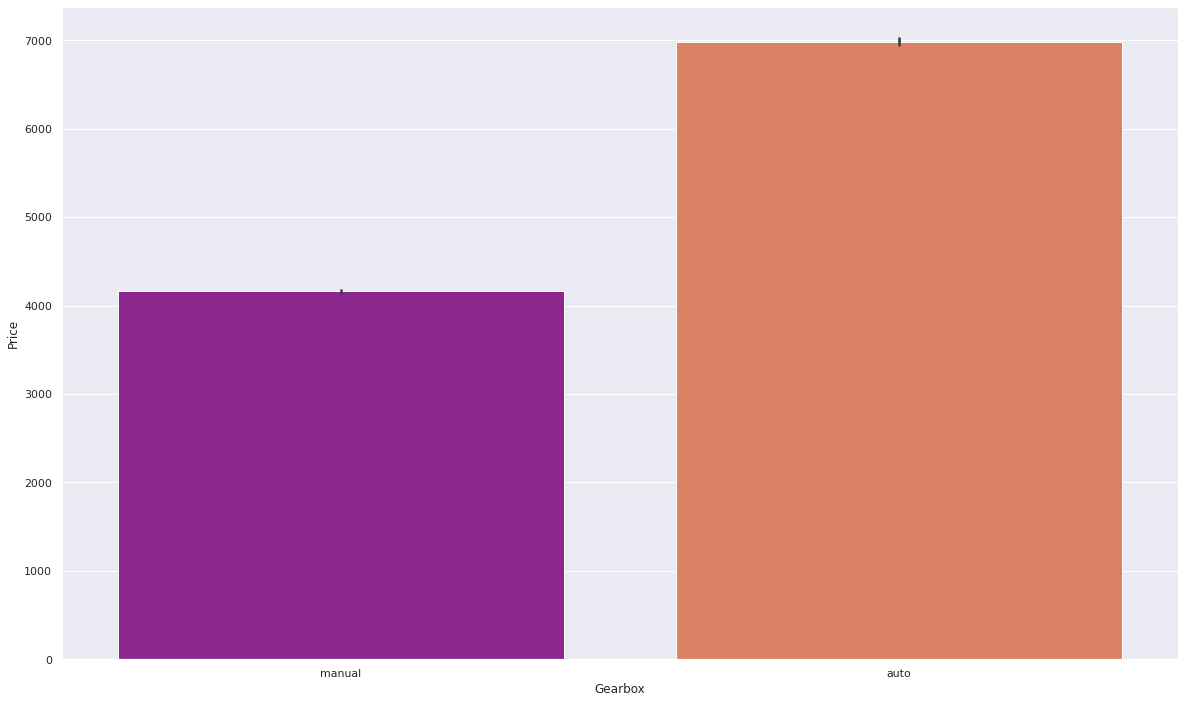

In [118]:
sns.barplot(x ='Gearbox', y ='Price', data = df, palette ='plasma')

Машины с автоматической трасмиссией - в среднем дороже, чем с механической

<AxesSubplot:xlabel='Repaired', ylabel='Price'>

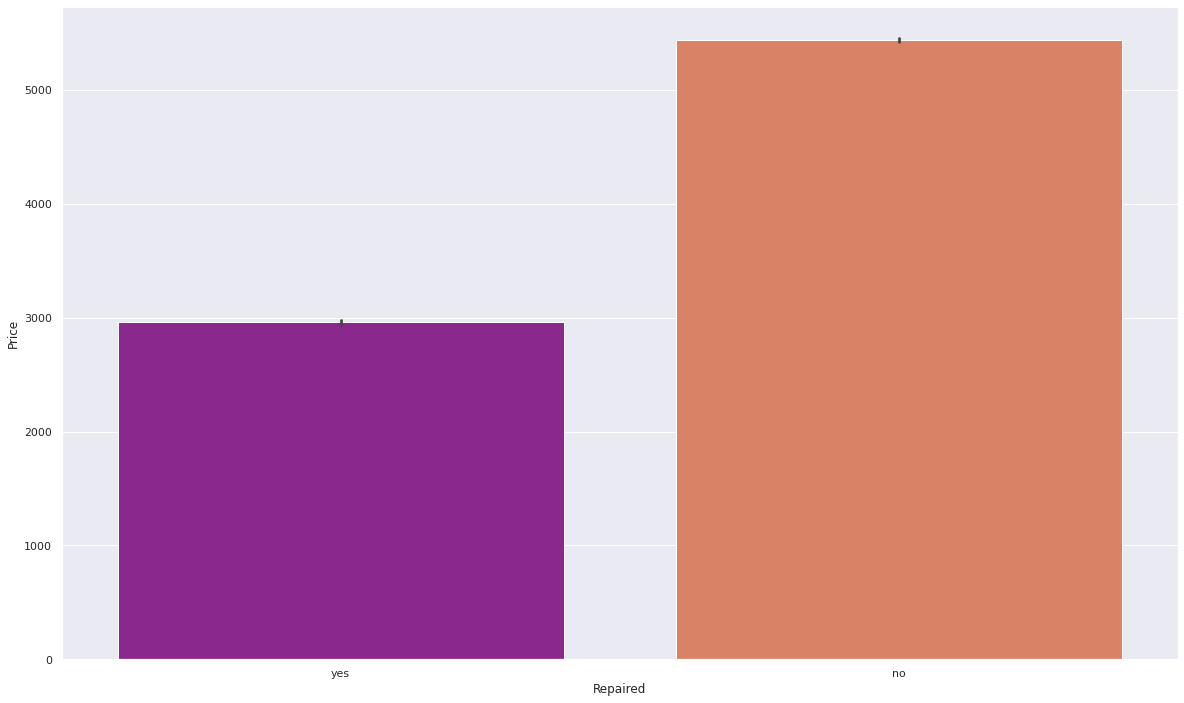

In [119]:
sns.barplot(x ='Repaired', y ='Price', data = df, palette ='plasma')

Логично, что авто которые не были в ремонте - дороже, чем авто которые были.

<function matplotlib.pyplot.show(close=None, block=None)>

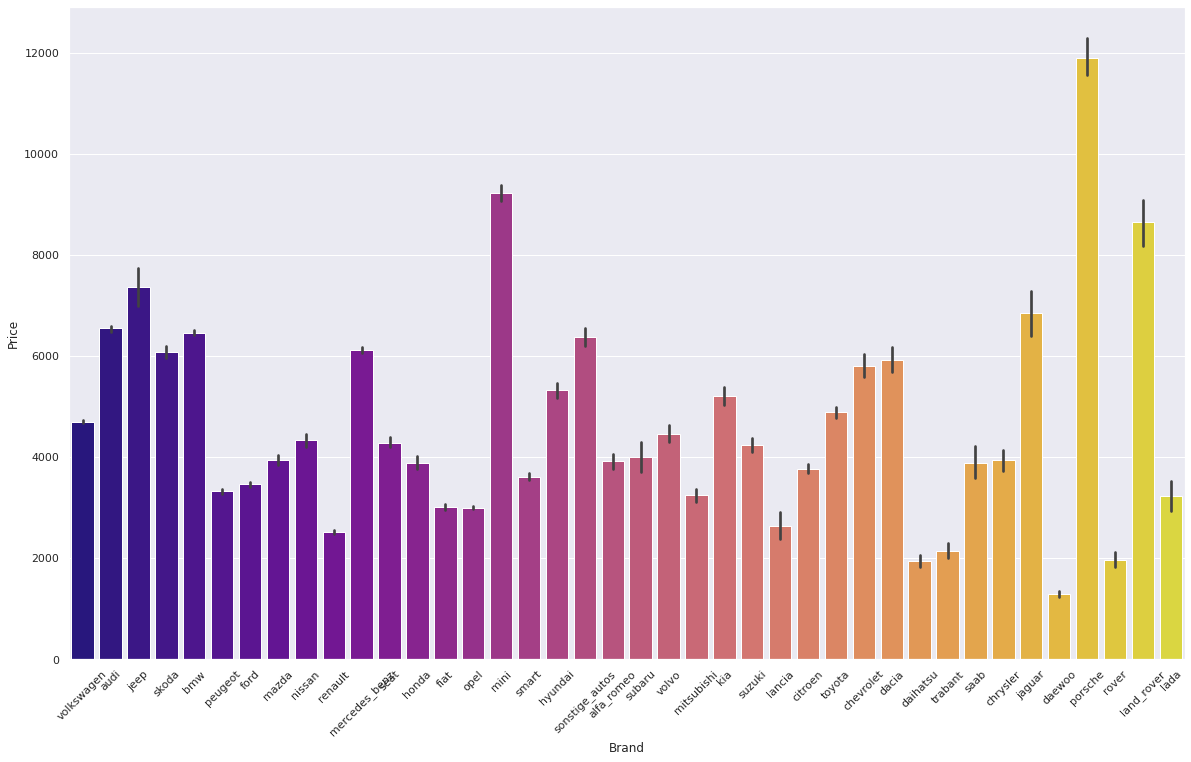

In [120]:
ax = sns.barplot(x ='Brand', y ='Price', data = df, palette ='plasma')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show

Самые дорогие авто марки Porshe, самые дешевые daewoo.

Трансформация признаков. 
Будем использовать категориальный кодировщик что бы не плодить признаки. Бренд и модель - много уникальных значений.

In [121]:
RANDOM_STATE = 12345

target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_testvalid, target_train,target_testvalid = train_test_split(features,target,test_size=.4,random_state=RANDOM_STATE)
features_test, features_valid, target_test,target_valid = train_test_split(features_testvalid,target_testvalid,
                                                                           test_size=.5,random_state=RANDOM_STATE)

print (target_train.shape)
print (features_train.shape)
print (target_test.shape)
print (features_test.shape)
print (target_valid.shape)
print (features_valid.shape)

(203752,)
(203752, 9)
(67917,)
(67917, 9)
(67918,)
(67918, 9)


In [122]:
numeric = ['Kilometer', 'AgeCar', 'Power']
scaler = RobustScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

encoder = CatBoostEncoder(cols=['VehicleType','FuelType', 'Model', 'Gearbox','Brand', 'Repaired'])
features_train_encoded = encoder.fit_transform(features_train, target_train)
features_test_encoded = encoder.transform(features_test)
features_valid_encoded = encoder.transform(features_valid)

features_train = pd.concat([features_train_encoded, features_train[numeric]], axis=1)
features_test = pd.concat([features_test_encoded, features_test[numeric]], axis=1)
features_valid = pd.concat([features_valid_encoded, features_valid[numeric]], axis=1)

In [123]:
features_train = features_train.loc[:, ~features_train.columns.duplicated()]
features_test = features_test.loc[:, ~features_test.columns.duplicated()]
features_valid = features_valid.loc[:, ~features_valid.columns.duplicated()]

## Обучение моделей

Линейную регрессию использую как дамми модель. Считает быстро, гиперпараметры настраивать не нужно.

In [124]:
%%time

model = LinearRegression().fit(features_train, target_train)

CPU times: user 83.5 ms, sys: 42.3 ms, total: 126 ms
Wall time: 128 ms


In [125]:
%%time

lr_pred = model.predict(features_valid)

CPU times: user 27 ms, sys: 27 ms, total: 54 ms
Wall time: 93 ms


In [126]:
lr_rmse = mean_squared_error(target_valid, lr_pred, squared=False) 

print ('RMSE', lr_rmse)

RMSE 2843.502206615812


CatBoostRegressor

In [133]:
%%time

model_2 = CatBoostRegressor(iterations = 2000, depth = 8, verbose = False, loss_function = 'RMSE', learning_rate = 0.01, random_state=RANDOM_STATE).fit(features_train, target_train)

CPU times: user 1min 25s, sys: 364 ms, total: 1min 25s
Wall time: 1min 27s


In [134]:
%%time

cbr_pred = model_2.predict(features_valid)

CPU times: user 208 ms, sys: 66 µs, total: 208 ms
Wall time: 211 ms


In [135]:
cbr_rmse = mean_squared_error(target_valid, cbr_pred, squared=False) 

print ('RMSE', cbr_rmse)

RMSE 1754.3905465898201


LGBMREgressor

In [130]:
%%time

model_3 = LGBMRegressor(n_estimators = 3000, max_depth = 12, metric = 'RMSE', learning_rate = 0.01, random_state=RANDOM_STATE).fit(features_train, target_train)

CPU times: user 57.4 s, sys: 309 ms, total: 57.7 s
Wall time: 58.1 s


In [131]:
%%time

lgb_pred = model_3.predict(features_valid)

CPU times: user 24.2 s, sys: 14.2 ms, total: 24.2 s
Wall time: 24.2 s


In [132]:
lgb_rmse = mean_squared_error(target_valid, lgb_pred, squared=False) 

print ('RMSE', lgb_rmse)

RMSE 1720.05243428012


## Анализ моделей

In [137]:
data = {
    'Модель': ['LinearRegression','CatBoostRegressor', 'LGBMRegressor'],
    'RMSE': [lr_rmse, cbr_rmse, lgb_rmse],
    'Время обучения': ['128 ms','1min 27s', '58.1 s'],
    'Скорость предсказания': ['93 ms','211 ms', '24.2 s']
    
}

results = pd.DataFrame(data)

print(results)

              Модель     RMSE Время обучения Скорость предсказания
0   LinearRegression 2,843.50         128 ms                 93 ms
1  CatBoostRegressor 1,754.39       1min 27s                211 ms
2      LGBMRegressor 1,720.05         58.1 s                24.2 s


Самая быстрая по времени обучения и скорости предсказания - линейная регрессия, но она же имеет самый высокий показатель ошибки. Между LGBMR И CBR практически паритет. LGBMR уступает тоько в скорости предсказания, в остальном немного но ппревосходит CBR. 

Для тестирования выбираем модель LGBMRegressor.

In [140]:
%%time

test_pred = model_3.predict(features_test)

CPU times: user 22.2 s, sys: 17.6 ms, total: 22.2 s
Wall time: 22.2 s


In [ ]:
print ('Final RMSE:', mean_squared_error(target_test, test_pred, squared=False) )

Оценка важности признаков:

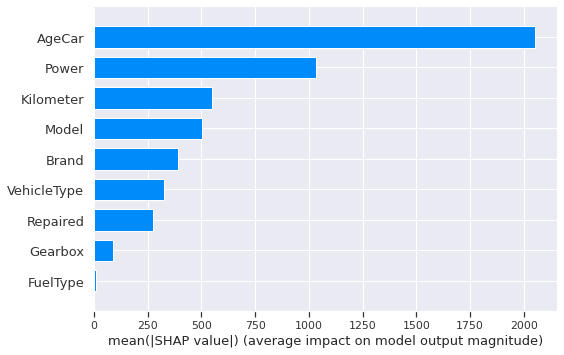

In [141]:
explainer = shap.Explainer(model_3)
shap_values = explainer.shap_values(features_test)
shap.summary_plot(shap_values, features_test, plot_type='bar')

Вывод. 

Возраст машины - основной признак влияющий на цену с отрывом, далее идет мощность - этот признак так же имеет значение. Остальные признаки: пробег, модель, марка, тип кузова, находилось авто в ремонте или нет - имеют одинаковое, среднее значение для модели. 

Трансмиссия и тип топлива - не важны.

Рекомендую модель LGBMRegressor. Показатель ошибки на тестовой выборке RMSE = 1734, скорость обучения на тренировочной выборке 58.1 s, скорость предсказания на тестовой выборке  22.2 s.